# It's Raining Cats and Dogs!
   
##  Lab Assignment Three: Exploring Image Data 
   
### Justin Ledford, Luke Wood, Traian Pop

## Business Understanding

### Overview
   
The data set we are analyzing has over 25000 evenly distributed pictures of dogs and cats. We found it on https://www.kaggle.com/c/dogs-vs-cats and decided it would be a good set to practice processing and analyzing image data due to the clear classification metric of dogs|cats and the large number of high quality photos.
 
### Purpose 
   
This data was originally collected for the purpose of a competition hosted by Kaggle to see who could create the most accurate algorithm that could distinguish between pictures of dogs and cats. Petfined.com are the original owners of the data, and they donated over 3 million pictures of sheltered animals that have been hand classified by them. Because of this, we are highly confident in the data, as the vast majority of humans can successfully identify between a dog and a cat. 
   
The competition itself is long over, but the page still remains for people to play and experiment with the data. This data is important due to potential it holds to help develop and train algorithms that could be used to evolve image recognition software. We can progressively check how useful the data we get from the set is by comparing it against our own classification and seeing if our own conclusions (i.e. if an image classifies a cat or not) match with the information we collect from it. 

### Predictions
   
We are not expecting perfect results as cats and dogs can look fairly similar at times, and the black and white color format of the pictures already limits easily differential characteristics between the two animals, such as fur color. However, we do believe that due to the large number and quality of the pictures, we can definitely expect to get a large amount of succesful results when processing and analyzing the data.

### Applications
This dataset could be used to train an image classifier that could be used by hotels or apartment that only allow one type of pet.  For example, Luke's apartment complex only allows cats to stay in the homes so the complex could theoretically place cameras in the hallway and test to see which type of pets are being brought in.  This would allow them to more efficiently enforce the no dogs rule which is frequently broken.  Another application is it could also be used for cataloging by a pet shelter to allow owners to search for cats or dogs similar to one they are looking for.

## Data Preparation
   
In this section, we pre-process the data in order to be usable by our techniques. The first method represents how we take all the images in a given folder (after they have been modified by our own scripts) and append them together to be analyzed later.
   
In pre-processing the data, we used three separate scripts:
   
<B>1) aspect</B>: Script developed by Fred Weinhaus (http://www.imagemagick.org/script/license.php) in order To resize an image to a specific size allowing either cropping or padding to deal with the aspect ratio change. (Not shown due to length)
   
<B>2) process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Uses padding to fill space leftover. Leaves all original content there, but adds noise to the edges to fill blanks.
   
<B>3) crop_process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Instead of padding, it simply crops the image in respective to the middle of the original image. Loses quality and detail but no additional noise is added.
   
Afterwards, we append them all together in one dataframe. 

In [101]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import glob
import plotly
import matplotlib.pyplot as plt
%matplotlib inline 

#ignore warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

w,h = 150,150

def wildcard_to_df(fpath, greyscale=True):
    X = []
    labels = []
    
    for img_file in glob.iglob(fpath):
        # Read in img as greyscale
        with Image.open(img_file).convert("L") as img:

            # Keep labels for each image in separate array
            if 'cat' in img_file:
                labels.append(0)
            else:
                labels.append(1)

            # Concatenate RGB into one row and collect
            X.append(np.concatenate(np.array(img)))

    X = np.array(X)
    labels = np.array(labels)

    #convert to DF
    return pd.DataFrame(data=X, index=labels), X, labels

### Padded Images
   
Initially we started preprocessing the data by shrinking the images while keeping dimension ratios similar. We filled the empty space remaining from the prefere 150 x 150 with black padding. We assumed this was the best solution due to us keeping the original image ratios and didn't initally take into account the affect the padding would have on the PCA. 

In [102]:
df, X, label = wildcard_to_df('data/barred/*.jpg')

The function below prints out the images in an organized way for us to examine them and see if they pre-processed correctly.

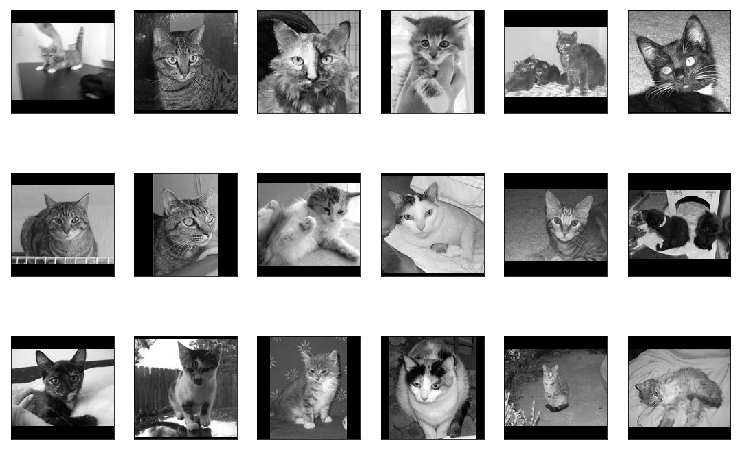

In [103]:
# a helper plotting function (modified code from Professor Eric Larson's repository)
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces

# Visualize some images
plt.show()

We set a default component value to 250 in order to safely overestimate the number of components it takes to accurately and efficiently represent our image data. This way, we can then analyze it later to find a more accurate component number.

#### Using PCA

In [172]:
from sklearn.decomposition import PCA

n_components = 250
pca = PCA(n_components=n_components)
%time pca.fit(X)
eigens = pca.components_.reshape((n_components, h, w))

CPU times: user 20.1 s, sys: 1.52 s, total: 21.7 s
Wall time: 10.1 s


This function performs linear dimensionality reduction (LDR) of the set of images given using principal component analysis. Then, it visualizes the explained variance of each component in the set of images. We use this information to see how many dimensions are needed to get the most accurate representation of our data set while still maintaining efficiency.

In [173]:
def plot_explained_variance(pca):
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

First, we will run the LDR on the padded images.

In [174]:
plot_explained_variance(pca)

From what we can tell in the graph, it seems that the first component only represents about 18.9% of the variance and it takes up to 171 components to reach a 90% or higher variance. When printing the eigen images afterwards, this is what we produce.

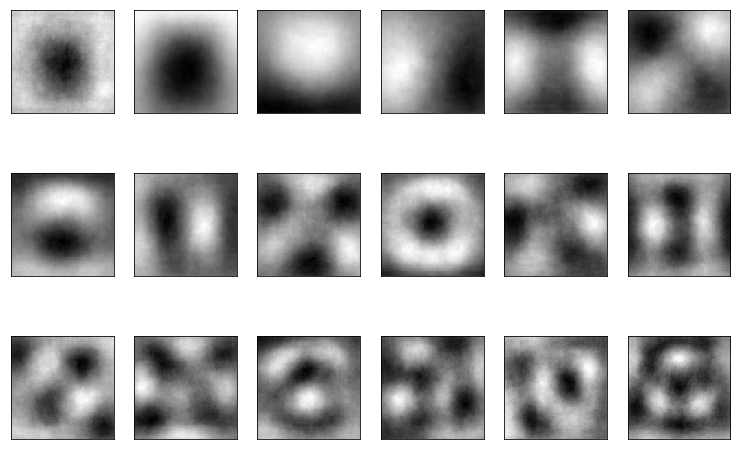

In [175]:
plot_gallery(eigens, h, w)
plt.show()

#### The issues with the current PCA
   
After running principal component analysis on our preprocessed images, we realized that we had a huge issue!  Almost every single component represented either dark edges or light edges.  These edges are not at all representative of the images themselves, but instead show which images we preprocessed to have dark borders or light borders.  We realized that we needed to find a different way to format the images so we instead tried cropping the data.

### Cropped Images
   
After some debate, we decided to try cropping the images to 150 x 150 in respect to the original middle point of the picture. Although we received less quality overall as we lost parts of the image, we predicted that we would get better results with the PCA due to less noise from the padding.

In [176]:
#convert to dataframe
df, X, labels = wildcard_to_df('data/cropped/*.jpg')

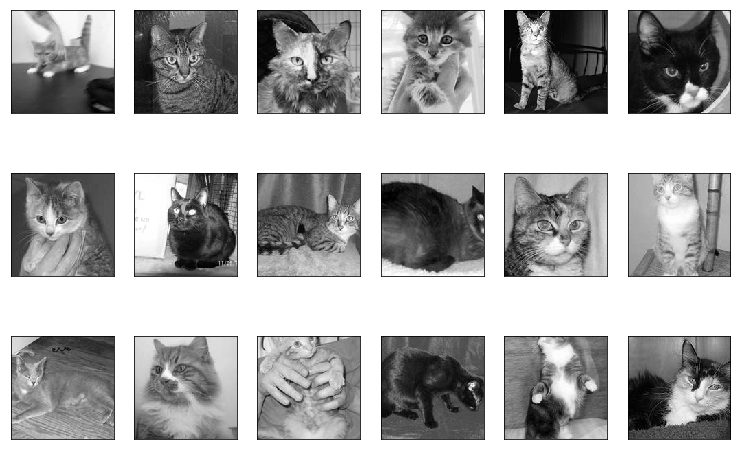

In [177]:
plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces

# Visualize some images
plt.show()

It is already noticeable how much easier the data is to look at, at least for a human. Although it is easy to also see that data will be lost in some of the key features (like the face) as we can see from row 2, image 4 (from the left).
   
We will be performing the same tests as we did for padding.

In [178]:
n_components = 250
pca = PCA(n_components=n_components)
%time pca.fit(X)
eigens = pca.components_.reshape((n_components, h, w))

CPU times: user 20.2 s, sys: 1.21 s, total: 21.4 s
Wall time: 9.19 s


In [179]:
plot_explained_variance(pca)

This time, it seems that the first component only represents about 19.0% of the variance but it takes up to 205 components to reach a 90% or higher variance. When plotting the eigen faces afterwards, this is what we produce.

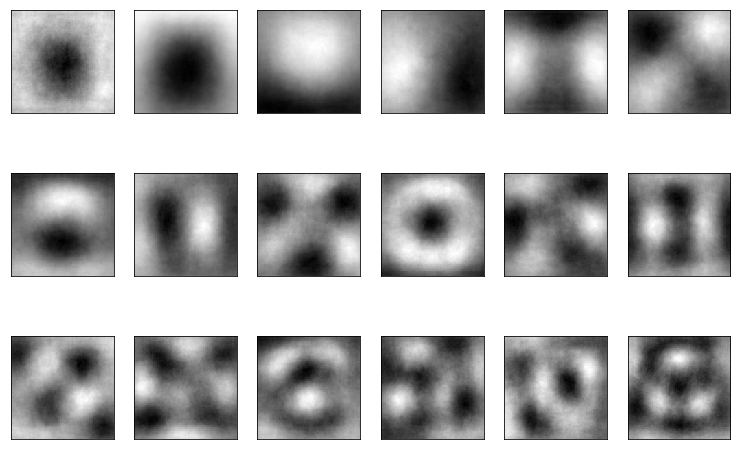

In [180]:
plot_gallery(eigens, h, w)
plt.show()

Although these eigen faces look more like nightmares than pets, it is clear to see that they are at least slightly more recognizable to, at least, a face than the previous set from the padded images. In the end, we chose to remain with the cropped images due to the noise factor being minimum.
   
Here is a summary of our final set of pre-processed data.

In [181]:
samples, features = X.shape
classes = len(np.unique(label))

print("Number of samples in dataset: {}".format(samples))
print("Number of features in dataset: {}".format(features))
print("Number of classes in dataset: {}".format(classes))
print("Original Image Sizes {} by {}".format(h,w))

Number of samples in dataset: 2000
Number of features in dataset: 22500
Number of classes in dataset: 2
Original Image Sizes 150 by 150


## Data Reduction 
(60 points total)

[10 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. How many dimensions are required to adequately represent your image data?
   
[10 points] Perform non-linear dimensionality reduction of your image data. Compare the representation using non-linear dimensions to using linear dimensions. Do you prefer one method over another? Why?
   
[20 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, etc.).
   
[20 points] Visualize the differences between instances in each target class. For example, a heat map of the pairwise differences among all instances is likely appropriate for you data. Do you think the features extracted are appropriate for classification on your dataset? 

### PCA and Randomized PCA

As done in the previous section, we performed and analyzed the linear dimensionality reduction using PCA, but we did not run it through using Randomized PCA. RPCA is typically used to manage larger data sets, but since our data set is fairly small, it should not affect the final outcome significantly.

In [182]:
from sklearn.decomposition import RandomizedPCA

n_components = 250
rpca = RandomizedPCA(n_components=n_components)
%time rpca.fit(X)
eigenfaces_r = rpca.components_.reshape((n_components, h, w))

CPU times: user 12.2 s, sys: 687 ms, total: 12.9 s
Wall time: 5.34 s


In [183]:
plot_explained_variance(rpca)

The Randomized PCA also had a top 19.0% variance ratio but reached a 90% or higher variance ratio at 209 components instead of the previous 205 by RCA. Next we will display the eigenfaces to see if there is any significant difference, but we predict that due to the small changes in the two numbers we just measured, there will be very little, if any, noticeable difference.

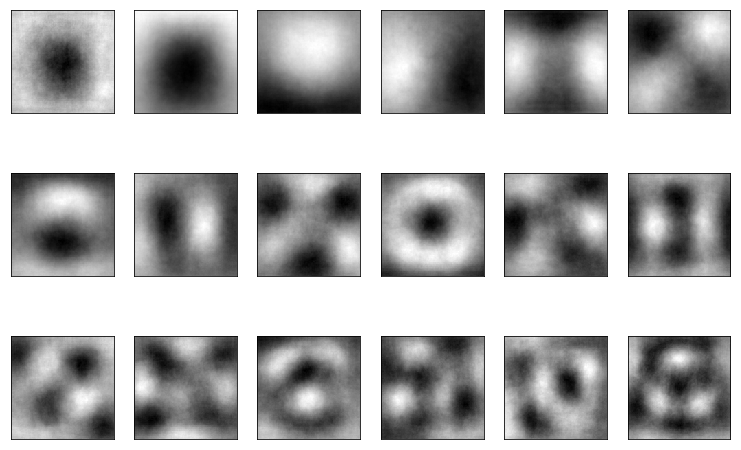

In [184]:
plot_gallery(eigenfaces_r, h, w)

As we predicted, the differences were miniscule. Now, we will compare the reconstruction capabilities between PCA and RPCA. The following method is used to reconstruct an image.

In [185]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 5
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct].reshape(1, -1))
low_dimensional_representation_r, reconstructed_image_r = reconstruct_image(pca,X[idx_to_reconstruct].reshape(1, -1))

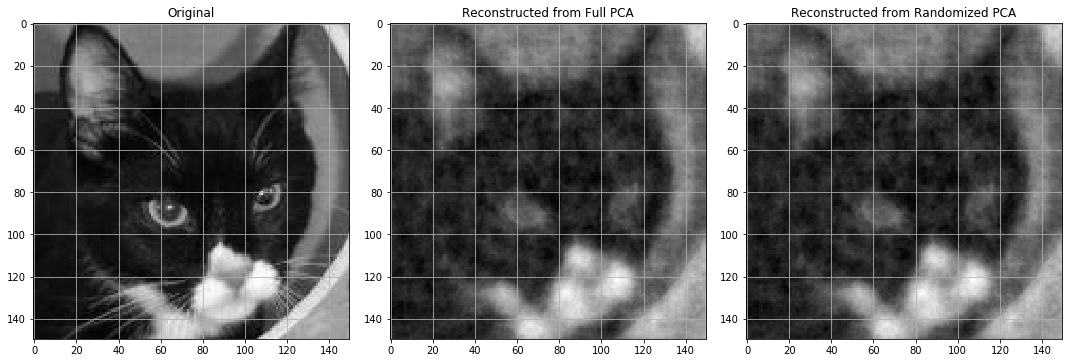

In [186]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()

plt.subplot(1,3,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()

plt.subplot(1,3,3)
plt.imshow(reconstructed_image_r.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Randomized PCA')
plt.grid()

plt.tight_layout()

The end results between the Full PCA and Randomized PCA look almost completly similar, and it is amazing to see how close both came to the original image. The image quality difference matches previous tests seen done on other data, so we are confident that this is the correct end product that reconstruction from PCA produces. Next, we will look at another way to reduce the dimensions of our images.

### Kernel PCA

In [17]:
#kernel
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)


Extracting the top 300 eigenfaces from 2000 faces
CPU times: user 21.1 s, sys: 639 ms, total: 21.8 s
Wall time: 9.08 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

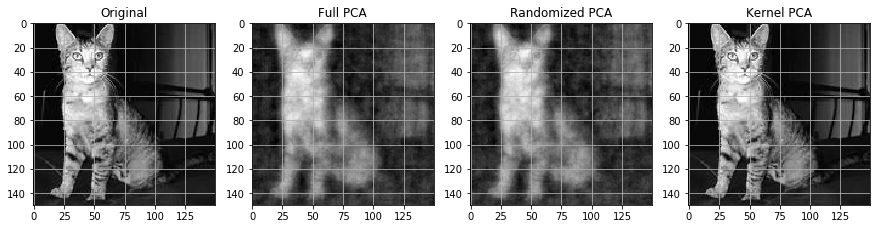

In [18]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid()
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()

plt_reconstruct(4)
#widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

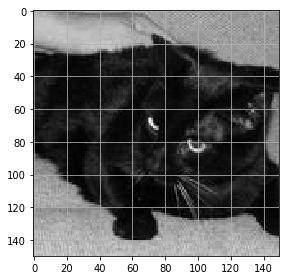

In [19]:
#image processing
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid()

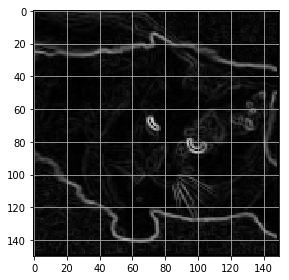

In [20]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()

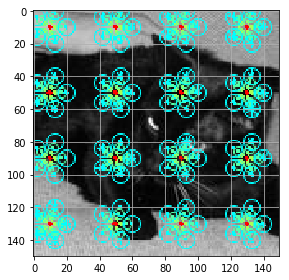

In [21]:
#daisy
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()

In [22]:
# now let's understand how to use it
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(13, 13, 72)
12168


In [23]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 35.7 ms, sys: 6.92 ms, total: 42.6 ms
Wall time: 43 ms


(17576,)

In [24]:
0.019 * len(X) # approximate how long it may run

38.0

In [25]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 1min 6s, sys: 9.38 s, total: 1min 15s
Wall time: 1min 17s
(2000, 17576)


In [26]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 4.52 s, sys: 38 ms, total: 4.56 s
Wall time: 1.35 s


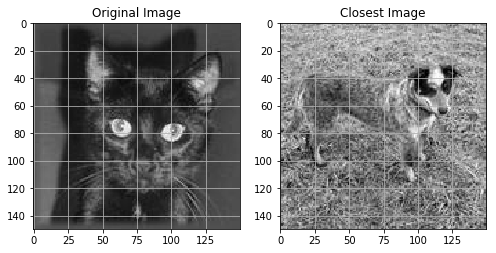

In [27]:
import copy
# find closest image to current image
idx1 = 112
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

In [28]:
from ipywidgets import fixed
from ipywidgets import widgets  # make this interactive!

# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image distances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image ")
    plt.grid()

#closest_image(idx1)
widgets.interact(closest_image,idx1=(0,1500-1,1),dmat=fixed(dist_matrix),__manual=True)

<function __main__.closest_image>

In [29]:
#garbor
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  1.00403467e+02,   3.93141612e+03,   6.73419151e-01,
        -2.71546944e-01,   3.17572000e+01,   6.63959580e+02,
         3.69327622e+00,   2.79232892e+01,   6.75632889e+01,
         1.65075767e+03,   7.11106124e-01,  -1.26943328e-01,
         3.09434667e+01,   6.80572141e+03,   2.32729522e+00,
         3.41914682e+00,   1.00405156e+02,   3.92999105e+03,
         6.73948754e-01,  -2.69858450e-01,   3.04574667e+01,
         4.02426965e+02,   9.57476174e-01,   3.58282566e+00,
         6.81550667e+01,   1.65683684e+03,   7.30418860e-01,
        -8.05290679e-02,   1.67536889e+01,   3.95958207e+03,
         3.51481585e+00,   1.03547509e+01,   1.00401467e+02,
         3.92890718e+03,   6.74599586e-01,  -2.68311002e-01,
         3.04087111e+01,   4.00526756e+02,   9.82162415e-01,
         3.68776689e+00,   6.75609778e+01,   1.62328083e+03,
         7.52492045e-01,  -3.16479892e-02,   2.45769778e+01,
         5.57246845e+03,   2.74494028e+00,   5.53679067e+00,
         1.00405467e+02,

In [30]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

CPU times: user 3min 2s, sys: 1.61 s, total: 3min 4s
Wall time: 3min 8s
(2000, 64)


In [31]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats)

CPU times: user 81.7 ms, sys: 22 ms, total: 104 ms
Wall time: 119 ms


In [32]:
widgets.interact(closest_image,idx1=(0,1500-1,1),dmat=fixed(dist_matrix),__manual=True)

<function __main__.closest_image>

# Cool Stuff
   
## Reverse Image Searching
   
We decided to simulate the scenario of someone searching for a pet in a shelter.  We used the images in our dataset to represent animals currently in the shelter, and I chose a picture of a cat from online to represent the cat I am searching for. 

Here is the type of cat I am looking for:

![alt text](img/orange-cat.jpg)

I then ran this to reformat the image to our format and added it to our dataset.  This gave us this image:

![alt text](img/orange-cat-cropped.jpg)

Here is the code used to find similar cats:

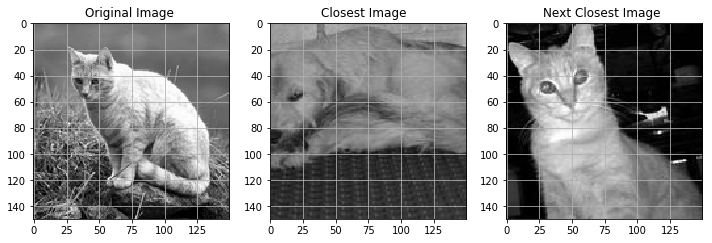

In [35]:
def search_for_cat(img_path):
    df0,X0,_=wildcard_to_df(img_path)
    gabor_search = compute_gabor(X0,kernels,(h,w))
    complete_gabor_stats = np.concatenate((gabor_search.reshape(1,-1),gabor_stats))
    dmat = pairwise_distances(complete_gabor_stats)
    distances = copy.deepcopy(dmat[idx1,:]) # get all image distances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X0.reshape((h,w)))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image ")
    plt.grid()
    
search_for_cat('img/orange-cat-cropped.jpg')

## Another Test

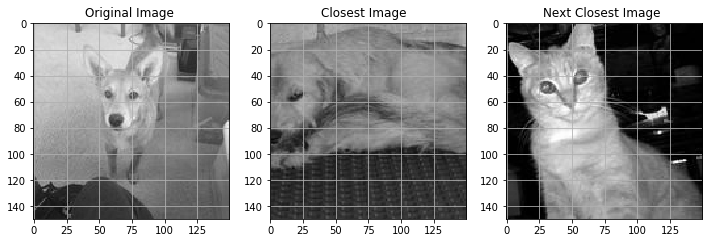

In [39]:
search_for_cat('img/nyx_dog.jpeg')

### Hooray
We have found a cat with a similar face and color scheme, along with another car that is standing in a similar pose!  This is good because we can see that matching by gabor filter distance has been a mild success.  

## Heat maps

To visualize the differences between some instances in each class we decided to plot the pairwise differences computed from the gabor filters in heatmaps. We choose a sample of 35 images from each class to compare to each other.

In [ ]:
import seaborn as sns

In [ ]:
sample_size = 30
cat_sample_indices = [i for i,x in enumerate(labels) if x == 0][:sample_size]
dog_sample_indices = [i for i,x in enumerate(labels) if x == 1][:sample_size]

cat_dist = dist_matrix[:, cat_sample_indices][cat_sample_indices, :]
dog_dist = dist_matrix[:, dog_sample_indices][dog_sample_indices, :]

max_dist = np.amax(dist_matrix)

In [ ]:
sns.heatmap(cat_dist, vmax=max_dist)

From the plot we can see that there are many images with relatively small differences, especially from images 9-25.

In [ ]:
sns.heatmap(dog_dist, vmax=max_dist)

We see the same trend in this heatmap as well.

In [ ]:
g = sns.heatmap(dist_matrix[:,np.arange(0,sample_size)][np.arange(0,sample_size),:],
                vmax=max_dist)
graph_labels = ["dog" if i == 1 else "cat" for i in labels[:sample_size]]
g.set(xticklabels=graph_labels, yticklabels=reversed(graph_labels))
#plt.yticks(rotation=30)
plt.xticks(rotation=90)

Plotting instances from both classes shows higher differences than plotting instances from the same class.